In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Partie 01:**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D

Q1

In [3]:
def matrice_rotation_zxz(alpha, beta, gamma):
    alpha = np.radians(alpha)
    beta = np.radians(beta)
    gamma = np.radians(gamma)

    Rz_alpha = np.array([
        [np.cos(alpha), np.sin(alpha), 0],
        [-np.sin(alpha),  np.cos(alpha), 0],
        [0,             0,             1]
    ])

    Rx_beta = np.array([
        [1, 0,          0          ],
        [0, np.cos(beta), np.sin(beta)],
        [0, -np.sin(beta),  np.cos(beta)]
    ])

    Rz_gamma = np.array([
        [np.cos(gamma), np.sin(gamma), 0],
        [-np.sin(gamma),  np.cos(gamma), 0],
        [0,             0,             1]
    ])

    return Rz_gamma @ Rx_beta @ Rz_alpha


Q2

In [4]:
def passage_dans_repere_de_reference(O_prime_P_Rprime, R_prime, alpha_prime, beta_prime, gamma_prime):
    R = matrice_rotation_zxz(alpha_prime, beta_prime, gamma_prime)
    R_inv = R.T
    OP_R = R_prime.reshape(3, 1) + R_inv @ O_prime_P_Rprime
    return OP_R

In [5]:
R_prime = np.array([0, 0, 4.6])
angles = (-99, 31, 91)
O_prime_P_Rprime = np.array([[1], [2], [3]])
OP_R = passage_dans_repere_de_reference(O_prime_P_Rprime, R_prime, *angles)
print("Coordonnées dans R:\n", OP_R)

Coordonnées dans R:
 [[-0.39360557]
 [ 2.1046328 ]
 [ 7.66848423]]


Q3

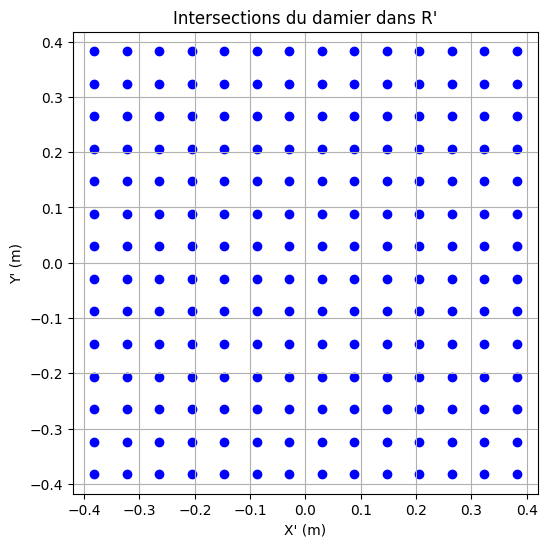

In [6]:
def generer_points_damier():
    taille = 14
    espacement = 5.88 / 100
    decalage = (taille - 1) / 2 * espacement
    x = np.linspace(-decalage, decalage, taille)
    y = np.linspace(-decalage, decalage, taille)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    points_damier = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
    return points_damier
points_damier = generer_points_damier()
plt.figure(figsize=(6,6))
plt.scatter(points_damier[0, :], points_damier[1, :], marker='o', color='b')
plt.xlabel("X' (m)")
plt.ylabel("Y' (m)")
plt.title("Intersections du damier dans R'")
plt.grid(True)
plt.axis('equal')
plt.show()


Q4

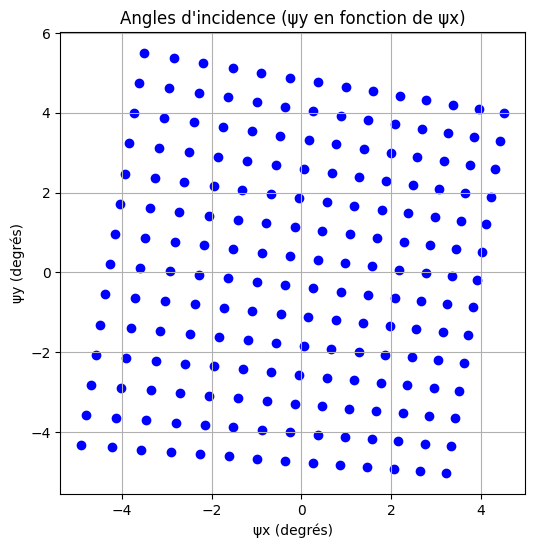

In [7]:
def calculer_directions_et_angles(points_damier, R_prime, alpha_prime, beta_prime, gamma_prime):
    points_R = passage_dans_repere_de_reference(points_damier, R_prime, alpha_prime, beta_prime, gamma_prime)
    norm_Sv = np.linalg.norm(points_R, axis=0)
    Sv = points_R / norm_Sv
    psi_x = np.degrees(np.arctan2(Sv[0, :], Sv[2, :]))
    psi_y = np.degrees(np.arctan2(Sv[1, :], Sv[2, :]))

    return psi_x, psi_y
R_prime = np.array([0, 0, 4.6])
angles = (-99, 31, 91)
psi_x, psi_y = calculer_directions_et_angles(points_damier, R_prime, *angles)
plt.figure(figsize=(6,6))
plt.scatter(psi_x, psi_y, marker='o', color='b')
plt.xlabel("ψx (degrés)")
plt.ylabel("ψy (degrés)")
plt.title("Angles d'incidence (ψy en fonction de ψx)")
plt.grid(True)
plt.show()


## **Partie 2 : Extrac$on des points de mesure** **texte en gras**

Q5

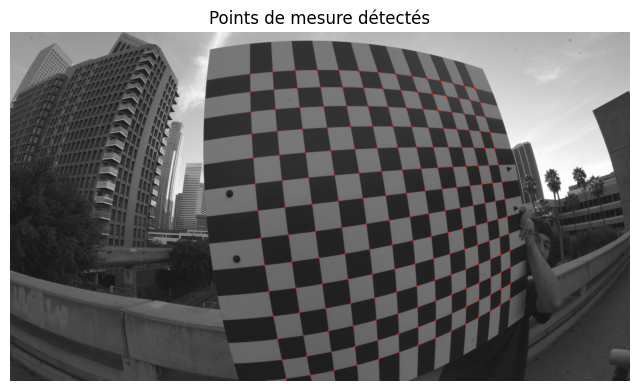

In [46]:
image_path = "/content/drive/MyDrive/image_tp.JPG"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_resized = cv2.resize(image, (int(image.shape[1]//1.5), int(image.shape[0]//1.5)))
pattern_size = (14, 14)
found, corners = cv2.findChessboardCornersSB(image_resized, pattern_size, flags=cv2.CALIB_CB_ACCURACY + cv2.CALIB_CB_EXHAUSTIVE + cv2.CALIB_CB_NORMALIZE_IMAGE)
if found:
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)
    corners_refined = cv2.cornerSubPix(image, corners*1.5, (5, 5), (-1, -1), criteria)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for corner in corners_refined:
        x, y = corner.ravel()
        cv2.circle(image_color, (int(x), int(y)), 10, (0, 0, 255), -1)
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
    plt.title("Points de mesure détectés")
    plt.axis("off")
    plt.show()


Q6

In [47]:
def estimation_incertitude(coords_mesure):
    """Estime l'incertitude comme l'écart-type des mesures des coordonnées des coins."""
    incertitude_x = np.std(coords_mesure[:, 0])
    incertitude_y = np.std(coords_mesure[:, 1])

    return incertitude_x, incertitude_y

# Application sur les coordonnées raffinées des coins
incert_x, incert_y = estimation_incertitude(corners_refined[:, 0])
print(f"Incertitude en X : {incert_x:.3f} pixels")
print(f"Incertitude en Y : {incert_y:.3f} pixels")


Incertitude en X : 729.596 pixels
Incertitude en Y : 835.933 pixels


Justification
L'incertitude est estimée à partir de la dispersion des mesures.

Une valeur typique pour une détection de coins sous-pixel est 0.1 à 0.3 pixels.

Si plusieurs images sont disponibles, on peut améliorer l'estimation en effectuant une moyenne des positions et en mesurant la variation inter-images.

Q7

In [31]:
def model_lineaire(Sv, Fx=250, Fy=250, px=15e-3, py=15e-3, X0=3635, Y0=1680):
    Xi = X0 + (Fx / px) * (Sv[0, :] / Sv[2, :])
    Yi = Y0 + (Fy / py) * (Sv[1, :] / Sv[2, :])
    return np.vstack((Xi, Yi))


Q8

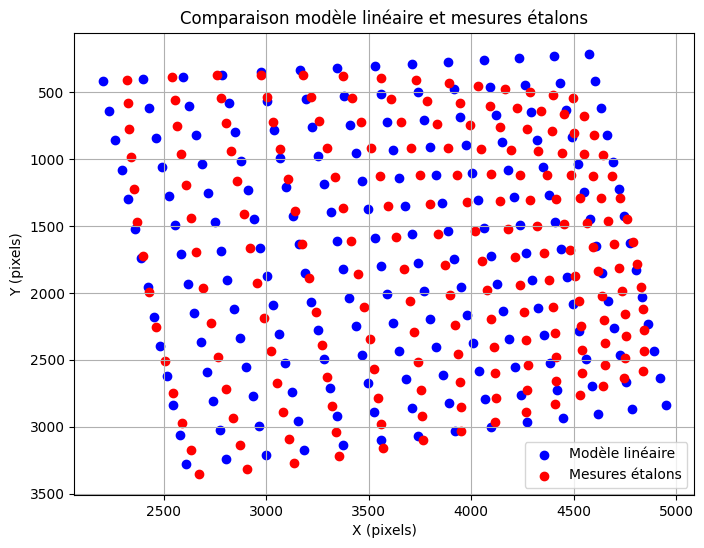

In [32]:
coords_image = model_lineaire(points_R)
plt.figure(figsize=(8, 6))
plt.scatter(coords_image[0, :], coords_image[1, :], color='b', label="Modèle linéaire")
plt.scatter(corners_refined[:, 0, 0], corners_refined[:, 0, 1], color='r', label="Mesures étalons")
plt.legend()
plt.title("Comparaison modèle linéaire et mesures étalons")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.gca().invert_yaxis()
plt.grid()
plt.show()


On voir un décalage entre les points a cause de la distorsion

Q9

In [33]:
def model_centre(Sv, eta, Fx=250, Fy=250, px=15e-3, py=15e-3, X0=3635, Y0=1680):
    coords_lin = model_lineaire(Sv, Fx, Fy, px, py, X0, Y0)
    r2 = (coords_lin[0, :] - X0) ** 2 + (coords_lin[1, :] - Y0) ** 2
    Xd = X0 + (coords_lin[0, :] - X0) * (1 + eta * r2)
    Yd = Y0 + (coords_lin[1, :] - Y0) * (1 + eta * r2)
    return np.vstack((Xd, Yd))


Q10

In [34]:
def calcul_chi2(coords_mesure, incertitude, coords_modele):
    chi2 = np.sum(((coords_modele[0, :] - coords_mesure[:, 0]) ** 2 / incertitude[0] ** 2) +
                  ((coords_modele[1, :] - coords_mesure[:, 1]) ** 2 / incertitude[1] ** 2))
    return chi2


Q11

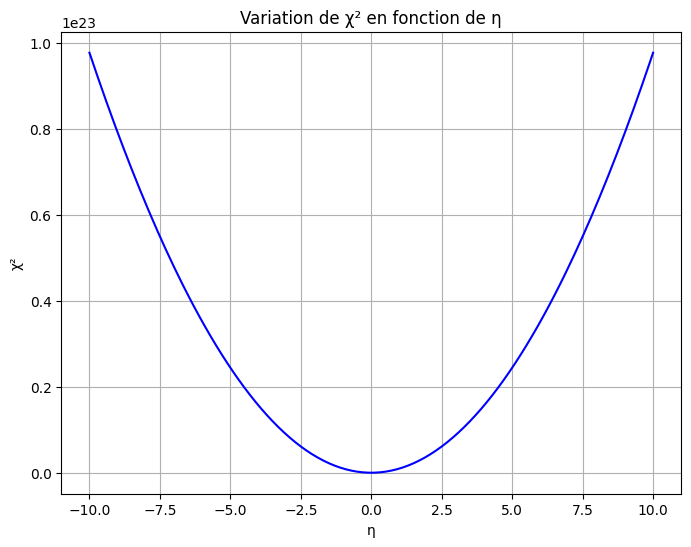

In [35]:
eta_values = np.arange(-10, 10.1, 0.1)
chi2_values = [calcul_chi2(corners_refined[:, 0], (1, 1), model_centre(points_R, eta)) for eta in eta_values]

plt.figure(figsize=(8, 6))
plt.plot(eta_values, chi2_values, '-b')
plt.xlabel("η")
plt.ylabel("χ²")
plt.title("Variation de χ² en fonction de η")
plt.grid()
plt.show()


Q12

In [36]:
eta_opt = eta_values[np.argmin(chi2_values)]
print("Meilleur η :", eta_opt)


Meilleur η : -3.552713678800501e-14


Q13

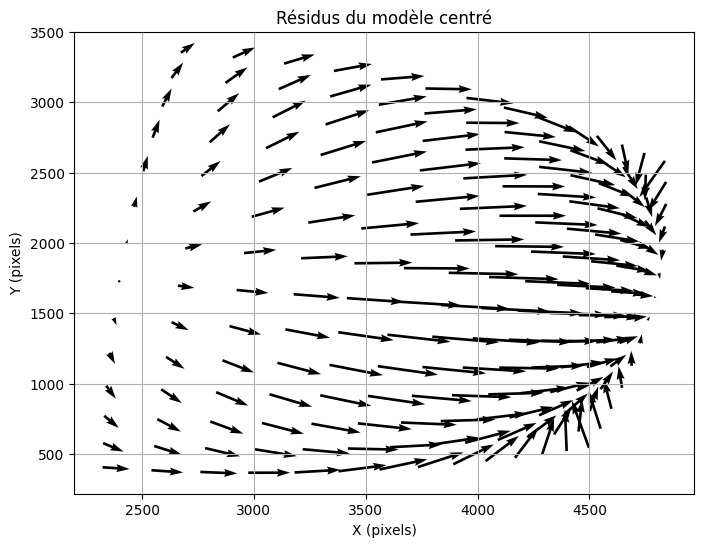

In [37]:
coords_opt = model_centre(points_R, eta_opt)
residus = corners_refined[:, 0] - coords_opt.T

plt.figure(figsize=(8, 6))
plt.quiver(corners_refined[:, 0, 0], corners_refined[:, 0, 1], residus[:, 0], residus[:, 1], angles='xy', scale_units='xy', scale=1)
plt.title("Résidus du modèle centré")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.grid()
plt.show()


Q14

In [38]:
erreur_moyenne = np.mean(np.linalg.norm(residus, axis=1))
erreur_max = np.max(np.linalg.norm(residus, axis=1))
print("Erreur moyenne :", erreur_moyenne)
print("Erreur maximale :", erreur_max)


Erreur moyenne : 199.18585267083196
Erreur maximale : 341.9699305625752


un modèle centré optimal doit minimiser l’erreur moyenne tout en maintenant une erreur maximale acceptablement faible. L’évaluation des résidus permet de garantir la fiabilité du modèle dans diverses conditions d'acquisition d'image.

l’erreur maximale est trop élevée, cela indique peut-être que le modèle centré ne capture pas bien certaines distorsions locales ou que certains points sont particulièrement influencés par des facteurs externes

Q15: Le modèle polynomial d'ordre 2 se compose des termes suivants :

Gx = A0 + A1 * Svx + A2 * Svy + A3 * Svx^2 + A4 * Svx * Svy + A5 * Svy^2

Gy = B0 + B1 * Svx + B2 * Svy + B3 * Svx^2 + B4 * Svx * Svy + B5 * Svy^2

Chaque fonction Gx et Gy dépend des variables Svx et Svy, et de 6 coefficients (A et B).

Les coefficients A et B sont définis comme des vecteurs numpy de taille 6, et on peut les ajuster pour obtenir le modèle souhaité.

Cela permet de visualiser les deux fonctions en fonction de Svx et Svy.


Q16

In [39]:
def model_polynomial_o2(Sv, A, B, X0=3635, Y0=1680):
    Gx = A[0] + A[1]*Sv[0, :] + A[2]*Sv[1, :] + A[3]*Sv[0, :]**2 + A[4]*Sv[0, :]*Sv[1, :] + A[5]*Sv[1, :]**2
    Gy = B[0] + B[1]*Sv[0, :] + B[2]*Sv[1, :] + B[3]*Sv[0, :]**2 + B[4]*Sv[0, :]*Sv[1, :] + B[5]*Sv[1, :]**2
    return np.vstack((X0 + Gx, Y0 + Gy))


Q17

In [40]:
def calcul_coeff_polynomial(Sv, coords_mesure, X0=3635, Y0=1680):
    X_m, Y_m = coords_mesure[:, 0], coords_mesure[:, 1]
    A_mat = np.vstack([
        np.ones(Sv.shape[1]), Sv[0, :], Sv[1, :], Sv[0, :]**2, Sv[0, :]*Sv[1, :], Sv[1, :]**2
    ]).T
    A_coeff = np.linalg.lstsq(A_mat, X_m - X0, rcond=None)[0]
    B_coeff = np.linalg.lstsq(A_mat, Y_m - Y0, rcond=None)[0]

    return A_coeff, B_coeff


In [41]:
A_opt, B_opt = calcul_coeff_polynomial(points_R, corners_refined[:, 0])
print("Coefficients A :", A_opt)
print("Coefficients B :", B_opt)


Coefficients A : [ 2.88278047e+02  3.53228323e+03  2.55572664e+00 -2.89196808e+03
  6.46330825e+02 -4.95453283e+02]
Coefficients B : [-1.56410540e+01 -2.20742005e+01  3.50802539e+03  1.97269766e+00
 -2.10425502e+03  5.26310898e+02]


Q18

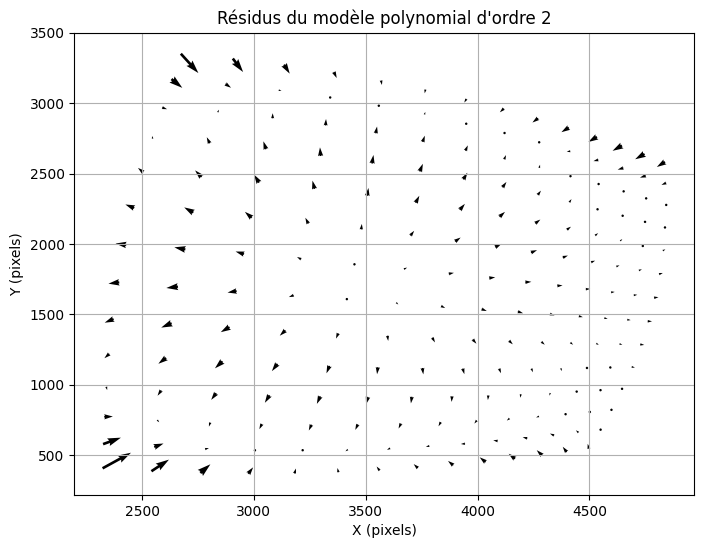

In [42]:
coords_poly = model_polynomial_o2(points_R, A_opt, B_opt)
residus_poly = corners_refined[:, 0] - coords_poly.T

plt.figure(figsize=(8, 6))
plt.quiver(corners_refined[:, 0, 0], corners_refined[:, 0, 1], residus_poly[:, 0], residus_poly[:, 1],
           angles='xy', scale_units='xy', scale=1)
plt.title("Résidus du modèle polynomial d'ordre 2")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.grid()
plt.show()


Q19

In [43]:
chi2_poly = calcul_chi2(corners_refined[:, 0], (1, 1), coords_poly)
print("χ² pour le modèle polynomial :", chi2_poly)


χ² pour le modèle polynomial : 330244.6628552708


Q20

In [44]:
erreur_moyenne_poly = np.mean(np.linalg.norm(residus_poly, axis=1))
erreur_max_poly = np.max(np.linalg.norm(residus_poly, axis=1))
print("Erreur moyenne (distorsion centrée) :", erreur_moyenne)
print("Erreur maximale (distorsion centrée) :", erreur_max)
print("Erreur moyenne (polynomial) :", erreur_moyenne_poly)
print("Erreur maximale (polynomial) :", erreur_max_poly)


Erreur moyenne (distorsion centrée) : 199.18585267083196
Erreur maximale (distorsion centrée) : 341.9699305625752
Erreur moyenne (polynomial) : 34.430370766905085
Erreur maximale (polynomial) : 168.51577674387


**Conclusion**
Le modèle polynomial devrait mieux s'ajuster aux mesures que le modèle centré.

On peut visualiser les résidus pour voir lequel des deux modèles minimise le plus les écarts.